In [41]:
'''
%%writefile ns.py
start = time.time()
end = time.time()
print(end-start)
'''
import tensorflow as tf
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os as os
import sys
from pathlib import Path
import sklearn as sk 
import time
import scipy.stats as stats
from sklearn.preprocessing.data import QuantileTransformer
from tensorflow.keras import regularizers

mhsdir = Path(os.getcwd()).parent
sys.path.append(os.path.join(mhsdir, 'src'))

import ns

datarawdir = os.path.join(mhsdir, 'data\\raw\\YC')
dataprepdir = os.path.join(mhsdir, 'data\\preprocessed')
dataprepnsdir = os.path.join(mhsdir, 'data\\preprocessed\\ns')
modeldir = os.path.join(mhsdir, 'models')
traindir = os.path.join(mhsdir, 'data\\train')

tempdatarawdir = os.path.join(mhsdir, 'temp\\data\\raw\\YC')
tempdataprepdir = os.path.join(mhsdir, 'temp\\data\\preprocessed')
tempdataprepnsdir = os.path.join(mhsdir, 'temp\\data\\preprocessed\\ns')

tfk = tf.keras
tfkl = tf.keras.layers

train_csv = os.path.join(traindir, 'train_real_0_0_410_38_40938.txt')
test_csv = os.path.join(traindir, 'train_real_410_0_9132.txt')

# Build model

In [5]:
def to_category(freqv): 
    res = np.zeros((freqv.shape[0],12))
    for i in range(freqv.shape[0]):
        if freqv[i] == 1:
            res[i] = np.array([1,1,1,1,1,1,1,1,1,1,1,1],dtype = 'float')
        elif freqv[i] == 2:
            res[i] = np.array([0,1,0,1,0,1,0,1,0,1,0,1],dtype = 'float') 
        elif freqv[i] == 3:
            res[i] = np.array([0,0,1,0,0,1,0,0,1,0,0,1],dtype = 'float')
        elif freqv[i] == 4:
            res[i] = np.array([0,0,0,1,0,0,0,1,0,0,0,1],dtype = 'float')
        elif freqv[i] == 6:
            res[i] = np.array([0,0,0,0,0,1,0,0,0,0,0,1],dtype = 'float')
        elif freqv[i] == 12:
            res[i] = np.array([0,0,0,0,0,0,0,0,0,0,0,1],dtype = 'float')
    return res

def convertor(df):
    df.columns = ['n','id','bmode','tb1','tb2','tb3','tb4','tb5','tb6','tb7','tb8','tb9','tb10','tb11','tb12','tb13','tb14','tb15','tb16','tb17','tb18','tb19','tb20','tb21',
           'ts1','ts2','ts3','ts4','ts5','ts6','ts7','ts8','ts9','ts10','ts11','ts12','ts13','ts14','ts15','ts16','ts17','ts18','ts19','ts20','ts21',
           't1','t2','t3','t4','t5','t6','t7','t8','t9','t10','t11','t12','t13','t14','t15','t16','t17','t18','t19','t20','t21',
           'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12','smode','freq']
    act_columns = ['tb1','tb2','tb3','tb4','tb5','tb6','tb7','tb8','tb9','tb10','tb11','tb12','tb13','tb14','tb15','tb16','tb17','tb18','tb19','tb20','tb21',
               'ts1','ts2','ts3','ts4','ts5','ts6','ts7','ts8','ts9','ts10','ts11','ts12','ts13','ts14','ts15','ts16','ts17','ts18','ts19','ts20','ts21',
               'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12']
    coup_columns = ['c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12'] 
    target = df[coup_columns].sum(axis=1)
    data = df[act_columns].copy()
    data.loc[:,coup_columns] = to_category(df['freq'])
    return data,target

def VaR(ar):
    sar = np.sort(ar)
    sz = sar.shape[0]
    rsk = np.rint(sz * (1 - np.array([0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.9]))).astype('int')
    return sar[rsk]

In [38]:
train_df = pd.read_csv(train_csv, sep = ';',header = None).iloc[:,:-1]
#train_df1 = pd.read_csv(train_csv, sep = ';',header = None)
#train_df2 = pd.read_csv(test_csv, sep = ';',header = None)
#train_df = pd.concat([train_df1,train_df2,train_real_df])
test_df = pd.read_csv(test_csv, sep = ';',header = None).iloc[:,:-1]

for i in range(100):
    train_df = train_df.sample(frac = 1).reset_index(drop=True)
    #test_df = test_df.sample(frac = 1).reset_index(drop=True)
train_data, train_target = convertor(train_df)
test_data, test_target = convertor(test_df)

lx = train_target > 0.1
train_data = train_data[lx]
train_target = train_target[lx]
lx = test_target > 0.1
test_data = test_data[lx]
test_target = test_target[lx]

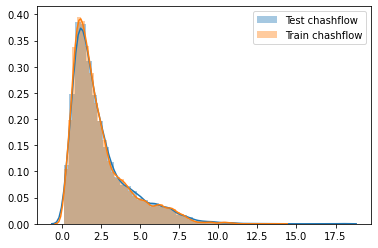

In [39]:
sn.distplot(test_target,label = 'Test chashflow')
sn.distplot(train_target,label = 'Train chashflow')
plt.legend()

In [42]:
model = tf.keras.Sequential([
                    tf.keras.layers.Dense(64, activation='relu',input_shape = [len(train_data.keys())]),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1(0.0001)),
                    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    #tf.keras.layers.Dense(64, activation='relu'),
                    #tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l=0.00001)),                 
                    #tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l=0.0001)),
                    tf.keras.layers.Dense(1)       
])
model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.Adagrad(0.001),
              metrics = ['mae','mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                3520      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [43]:
EPOCHS = 20
history = model.fit(
  train_data, train_target,
  batch_size = 64,
  epochs=EPOCHS, validation_data=(test_data,test_target))

Epoch 1/20
625/625 [==============================] - 1s 2ms/step - loss: 1.8957 - mae: 0.8911 - mse: 1.7185 - val_loss: 0.6524 - val_mae: 0.4671 - val_mse: 0.4750
Epoch 2/20
625/625 [==============================] - 1s 2ms/step - loss: 0.3659 - mae: 0.3054 - mse: 0.1886 - val_loss: 0.4070 - val_mae: 0.3082 - val_mse: 0.2298
Epoch 3/20
625/625 [==============================] - 1s 2ms/step - loss: 0.3010 - mae: 0.2496 - mse: 0.1238 - val_loss: 0.3653 - val_mae: 0.2653 - val_mse: 0.1883
Epoch 4/20
625/625 [==============================] - 1s 2ms/step - loss: 0.2826 - mae: 0.2301 - mse: 0.1057 - val_loss: 0.3478 - val_mae: 0.2507 - val_mse: 0.1709
Epoch 5/20
625/625 [==============================] - 1s 2ms/step - loss: 0.2705 - mae: 0.2154 - mse: 0.0938 - val_loss: 0.3296 - val_mae: 0.2365 - val_mse: 0.1529
Epoch 6/20
625/625 [==============================] - 1s 2ms/step - loss: 0.2617 - mae: 0.2049 - mse: 0.0852 - val_loss: 0.3259 - val_mae: 0.2326 - val_mse: 0.1495
Epoch 7/20
625/6

In [44]:
y_act = test_target.to_numpy()
y_pred = model.predict(test_data).reshape(-1)

In [45]:
VaR(y_act)

array([0.22622515, 0.31700304, 0.39570619, 0.45365751, 0.5111418 ,
       0.56637787, 0.61283443, 0.6572477 , 0.69763966, 0.73336264])

In [46]:
VaR(y_pred)

array([0.28023952, 0.3673098 , 0.4366684 , 0.4818223 , 0.522219  ,
       0.55153257, 0.5760806 , 0.6138604 , 0.64091176, 0.6721372 ],
      dtype=float32)

In [47]:
dff = pd.DataFrame({'Act': test_target, 'Pred' : y_pred})
dff.describe()

,Act,Pred
count,8942.000000,8942.000000
mean,2.447931,2.437514
std,1.899557,1.847497
min,0.101772,-0.155553
25%,1.132575,1.099985
50%,1.839844,1.862129
75%,3.127393,3.193925
max,18.057307,11.974199


<AxesSubplot:>

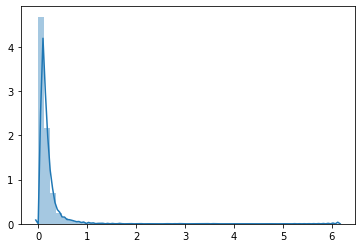

In [34]:
sn.distplot(np.abs(y_act-y_pred))

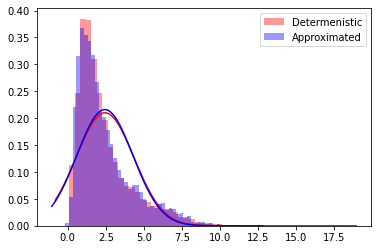

In [48]:
sn.distplot(y_act,fit = stats.norm, color = 'red', label = 'Determenistic',fit_kws={"color":"red"},kde = False)
sn.distplot(y_pred, fit = stats.norm, color = 'blue', label = 'Approximated',fit_kws={"color":"blue"},kde=False)
plt.legend()

In [18]:
version = 1
export_path = os.path.join(modeldir, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')

export_path = C:\Users\PLDD\Practice\GitHub\Python\MHS\models\1

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\PLDD\Practice\GitHub\Python\MHS\models\1\assets

Saved model:
